In [1]:
!pip install -q tfds-nightly
!pip install tensorflow_text
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from sklearn.model_selection import train_test_split

from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
# from keras.utils import plot_model

import time
import pandas as pd



     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 4.4 MB 5.3 MB/s 


In [2]:
use_builtins = True

In [3]:

df = pd.read_csv('/content/pure_tunis_english_data.csv')

train_data, valid_data = train_test_split(df, test_size=0.2, random_state = 42)
train_data.to_csv('train_data.csv')
valid_data.to_csv('valid_data.csv')

train = pd.read_csv('/content/train_data.csv')
valid = pd.read_csv('/content/valid_data.csv')


In [4]:

targ, inp = [], []
for eng in train['en']:
  targ.append(eng)
for tun in train['tn']:
  inp.append(tun)
# train_examples = tf.data.Dataset.from_tensor_slices((inputs,targets))


In [5]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [6]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'\xd8\xaa\xd9\x92\xd9\x88\xd9\x8e\xd9\x87\xd9\x91\xd9\x90\xd8\xac\xd9\x92'
 b'\xd9\x86\xd9\x8e\xd8\xa7\xd8\xb1\xd9\x92 \xd9\x85\xd9\x8f\xd9\x88\xd9\x82\xd9\x92\xd8\xaf\xd9\x8e\xd8\xa9\xd9\x92'
 b'\xd8\xb7\xd9\x8e\xd8\xa7\xd8\xba\xd9\x8f\xd9\x88\xd8\xaa\xd9\x92'
 b'\xd9\x83\xd9\x8e\xd8\xa7\xd9\x84\xd9\x90\xd9\x8a\xd8\xb3\xd9\x92'
 b'\xd9\x81\xd9\x92\xd9\x84\xd9\x8e\xd8\xa7\xd8\xb4\xd9\x92'], shape=(5,), dtype=string)

tf.Tensor(
[b'glow, shine' b'very hot fire' b'tyrant, despot' b'horse cart'
 b'quick spot on TV'], shape=(5,), dtype=string)


In [7]:
example_text = tf.constant("شد الحبل بالقوي وماتسيبوش")

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xd8\xb4\xd8\xaf \xd8\xa7\xd9\x84\xd8\xad\xd8\xa8\xd9\x84 \xd8\xa8\xd8\xa7\xd9\x84\xd9\x82\xd9\x88\xd9\x8a \xd9\x88\xd9\x85\xd8\xa7\xd8\xaa\xd8\xb3\xd9\x8a\xd8\xa8\xd9\x88\xd8\xb4'
b'\xd8\xb4\xd8\xaf \xd8\xa7\xd9\x84\xd8\xad\xd8\xa8\xd9\x84 \xd8\xa8\xd8\xa7\xd9\x84\xd9\x82\xd9\x88\xd9\x8a \xd9\x88\xd9\x85\xd8\xa7\xd8\xaa\xd8\xb3\xd9\x8a\xd8\xa8\xd9\x88\xd8\xb4'


In [8]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text
def tf_tun_pre(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [9]:
print(example_text.numpy().decode())
print(tf_tun_pre(example_text).numpy().decode())

شد الحبل بالقوي وماتسيبوش
[START] شد الحبل بالقوي وماتسيبوش [END]


In [10]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(
    standardize=tf_tun_pre,
    max_tokens=max_vocab_size)

In [11]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'فِي',
 'مَا',
 'عَلَى',
 'مْتَاعْ',
 'عْمَلْ',
 'عْلِيهْ']

In [12]:
output_text_processor = preprocessing.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', ',', 'to', 'a', 'the', 'of', 'he']

In [13]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 9), dtype=int64, numpy=
array([[   2,    1,    3,    0,    0,    0,    0,    0,    0],
       [   2,   54,  870,    3,    0,    0,    0,    0,    0],
       [   2, 1276,    3,    0,    0,    0,    0,    0,    0]])>

In [14]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] [UNK] [END]      '

Text(0.5, 1.0, 'Mask')

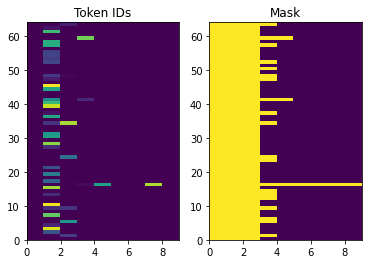

In [15]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [16]:
embedding_dim = 256
units = 1024

In [17]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    
    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
   

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)

    # 4. Returns the new sequence and its state.
    return output, state

In [18]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 9)
Encoder output, shape (batch, s, units): (64, 9, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )

    return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(units)

In [21]:
(example_tokens != 0).shape

TensorShape([64, 9])

In [22]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 9)


Text(0.5, 1.0, 'Mask')

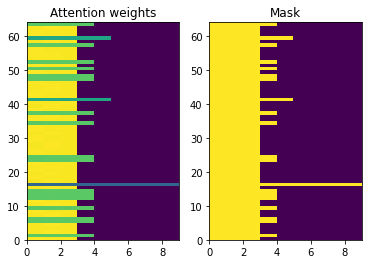

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [24]:
attention_weights.shape

TensorShape([64, 2, 9])

In [25]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

<Figure size 432x288 with 0 Axes>

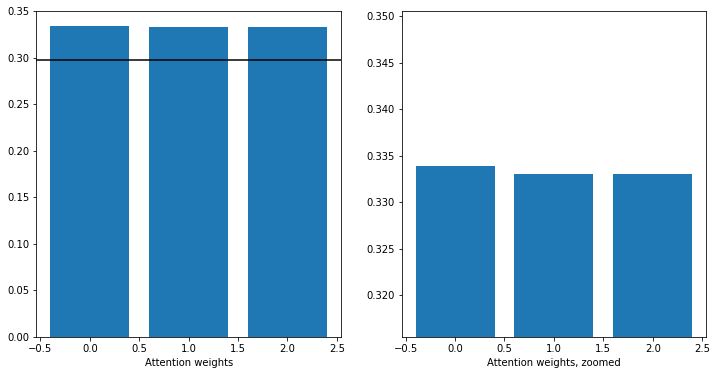

In [26]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [28]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [29]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)

  return DecoderOutput(logits, attention_weights), state

In [30]:
Decoder.call = call

In [31]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [32]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [33]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [34]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [35]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['stipulation'],
       ['furious'],
       ['after'],
       ['transparency'],
       ['hid']], dtype='<U18')

In [36]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['fiscal'],
       ['weighlifting'],
       ['experiment'],
       ['iran'],
       ['babies']], dtype='<U18')

In [37]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [38]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [39]:
def _preprocess(self, input_text, target_text):
  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)

  # Convert IDs to masks.
  input_mask = input_tokens != 0

  target_mask = target_tokens != 0

  return input_tokens, input_mask, target_tokens, target_mask


In [40]:
TrainTranslator._preprocess = _preprocess

In [41]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target the target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [42]:
TrainTranslator._train_step = _train_step

In [43]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [44]:
TrainTranslator._loop_step = _loop_step

In [45]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(), metrics=['accuracy']
)

In [46]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [47]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.2347836>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.1927032>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.102433>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.826153>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.877384>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7631645>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2894855>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9675953>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.780617>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.7142568>}

CPU times: user 7.09 s, sys: 198 ms, total: 7.29 s
Wall time: 9.34 s


In [48]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [49]:
TrainTranslator._tf_train_step = _tf_train_step

In [50]:
translator.use_tf_function = True

In [51]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.680747>}

In [52]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.661751>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.654793>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.6558292>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.640708>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5673046>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.463248>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.414868>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4538958>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.4618282>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3958445>}

CPU times: user 6.28 s, sys: 751 ms, total: 7.03 s
Wall time: 7 s


....................................................................................................


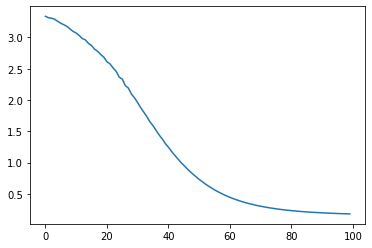

In [53]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [54]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(), metrics=['accuracy']
)

In [55]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [56]:
train_translator.fit(dataset, epochs=50,
                     callbacks=[batch_loss])

Epoch 1/50
163/163 [==============================] - 68s 376ms/step - batch_loss: 4.5773
Epoch 2/50
163/163 [==============================] - 58s 357ms/step - batch_loss: 3.9479
Epoch 3/50
163/163 [==============================] - 58s 358ms/step - batch_loss: 3.6372
Epoch 4/50
163/163 [==============================] - 59s 360ms/step - batch_loss: 3.3409
Epoch 5/50
163/163 [==============================] - 58s 357ms/step - batch_loss: 3.0340
Epoch 6/50
163/163 [==============================] - 58s 353ms/step - batch_loss: 2.6962
Epoch 7/50
163/163 [==============================] - 58s 356ms/step - batch_loss: 2.3236
Epoch 8/50
163/163 [==============================] - 58s 355ms/step - batch_loss: 1.9644
Epoch 9/50
163/163 [==============================] - 58s 358ms/step - batch_loss: 1.6297
Epoch 10/50
163/163 [==============================] - 59s 360ms/step - batch_loss: 1.3379
Epoch 11/50
163/163 [==============================] - 59s 363ms/step - batch_loss: 1.1049
Epoch 12

Text(0, 0.5, 'CE/token')

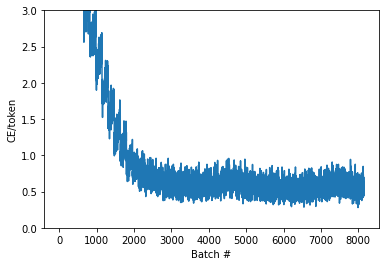

In [57]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [58]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [59]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [60]:
def tokens_to_text(self, result_tokens):
  
  result_text_tokens = self.output_token_string_from_index(result_tokens)


  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')


  result_text = tf.strings.strip(result_text)

  return result_text

In [61]:
Translator.tokens_to_text = tokens_to_text

In [62]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'confess riding', b'nap fancy', b'necessary sit', b'brik womans',
       b'super courageous'], dtype=object)

In [63]:
def sample(self, logits, temperature):
  # 't' is usually 1 here.


  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]


  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)


  return new_tokens

In [64]:
Translator.sample = sample

In [65]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 618],
       [3803],
       [ 946],
       [3429],
       [1322]])>

In [66]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [67]:
Translator.translate = translate_unrolled

In [96]:
%%time
input_text = tf.constant([
    "شد إلكرسي من ساقو ورماه", # "He took the chair with his leg and threw it."
    "خذينا الطيارة بش نمشيو لجربة", # "We took the flight to go to Jerba.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

he took the chair with his leg and threw it .
we took the flight to go to jerba .

CPU times: user 326 ms, sys: 1.18 ms, total: 327 ms
Wall time: 343 ms


In [69]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [70]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 23 s, sys: 591 ms, total: 23.5 s
Wall time: 23.3 s


In [71]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

to use republic at the public baths
we took the flight to go to jerba .

CPU times: user 201 ms, sys: 35.3 ms, total: 237 ms
Wall time: 303 ms


In [72]:
#@title [Optional] Use a symbolic loop
def translate_symbolic(self,
                       input_text,
                       *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):


  batch_size = tf.shape(input_text)[0]

  # Encode the input
  input_tokens = self.input_text_processor(input_text)
 

  enc_output, enc_state = self.encoder(input_tokens)
  
  # Initialize the decoder
  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)


  # Initialize the accumulators
  result_tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
  attention = tf.TensorArray(tf.float32, size=1, dynamic_size=True)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)


  for t in tf.range(max_length):
    dec_input = DecoderInput(
        new_tokens=new_tokens, enc_output=enc_output, mask=(input_tokens != 0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention = attention.write(t, dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)


    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens = result_tokens.write(t, new_tokens)

    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  result_tokens = result_tokens.stack()

  result_tokens = tf.squeeze(result_tokens, -1)
  result_tokens = tf.transpose(result_tokens, [1, 0])
 

  result_text = self.tokens_to_text(result_tokens)
  
  if return_attention:
    attention_stack = attention.stack()
   

    attention_stack = tf.squeeze(attention_stack, 2)
   

    attention_stack = tf.transpose(attention_stack, [1, 0, 2])
    

    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [73]:
Translator.translate = translate_symbolic

In [74]:
%%time
result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

to gain control over an area military
we took the flight to go to jerba .

CPU times: user 169 ms, sys: 2.43 ms, total: 172 ms
Wall time: 172 ms


In [75]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [76]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.35 s, sys: 33.9 ms, total: 1.39 s
Wall time: 1.37 s


In [77]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

to state information
we took the flight to go to jerba .

CPU times: user 77.2 ms, sys: 9.78 ms, total: 87 ms
Wall time: 74.4 ms


In [78]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

[1.         1.         0.99999994 1.         1.         0.99999994
 1.         0.99999994 1.         1.        ]


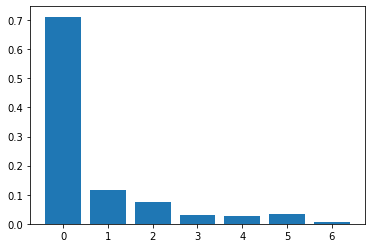

In [79]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

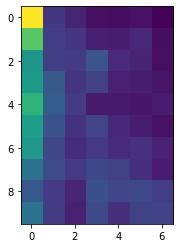

In [80]:
plt.imshow(np.array(a), vmin=0.0)

In [83]:
%%time
three_input_text = tf.constant([
    # "Grab the rope well and don't let go."
    "شد الحبل بالقوي وماتسيبوش",
    # "I felt like he was on guard and didn't want anyone to come near him or talk with him."
    "حسيتو شاد ڨارد وما يحبش حتى حد يقربلو والا يحكي معاه",
    # "He tampered with checks and so went to jail."
    "ترفك الشيكات ياخي شد الحبس",
])

result = translator.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

grab the rope well and dont let go .
i felt like he was on guard and didnt want anyone to come near him or talk with him .
he tampered with branches and so went to jail .

CPU times: user 151 ms, sys: 33.6 ms, total: 185 ms
Wall time: 154 ms


In [84]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'grab the rope well and dont let go .',
       b'i felt like he was on guard and didnt want anyone to come near him or talk with him .',
       b'he tampered with branches and so went to jail .'], dtype=object)>

In [85]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 the Tunisian dialect


In [86]:
tf.saved_model.save(translator, 'translator',
                    signatures={'serving_default': translator.tf_translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [87]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [88]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

grab the rope well and dont let go .
i felt like he was on guard and didnt want anyone to come near him or talk with him .
he tampered with branches and so went to jail .

CPU times: user 160 ms, sys: 16.4 ms, total: 176 ms
Wall time: 152 ms


In [93]:
%%time
result = reloaded.tf_translate( tf.constant([
                    "عرضها راجلها قالها يا مهبولة آش تعمل! قتلو شبيك علااش ؟",
                    "يا عمي تعطيني كعيبتين سفنج ونعطيك ه البهيم؟"]))

for tr in result['text']:
  print(tr.numpy().decode())

print()

after evening course , youll are want to die people at us to come on
how terrible , oh no only used by women

CPU times: user 116 ms, sys: 10.2 ms, total: 126 ms
Wall time: 240 ms


In [94]:
def uni_bleu(references, sentence):
    """function  that calculates the unigram BLEU score for a sentence"""
    c = len(sentence)
    bp = brevity_penalty(sentence, references)
    words = count_clip_ngram(sentence, references)
    p = sum(words.values())
    return bp * p / c


def brevity_penalty(candidate, references):
    """
    Brevity Penalty
    BP={1 if c>r or exp(1−r/c)if c≤r
    c: length of candidate translation
    r: effective reference length
    """
    c = len(candidate)
    r = np.array([len(r) for r in references])
    r = np.argmin(np.abs(r - c))
    r = len(references[r])
    if c > r:
        return 1
    else:
        return np.exp(1 - float(r) / c)


def count_clip_ngram(sentence, references):
    """
    Countclip=min(Count,Max_Ref_Count)
    """
    words = dict()
    for word in sentence:
        for ref in references:
            if word in words:
                if words[word] < ref.count(word):
                    words.update({word: ref.count(word)})
            else:
                words.update({word: ref.count(word)})
    return words


In [95]:
references = []

for eng in df['tn']:
  references.append(eng)

sentence = "عرضها راجلها قالها يا مهبولة آش تعمل! قتلو شبيك علااش ؟".split()
print(uni_bleu(references, sentence))

0.45454545454545453


In [92]:
sentence = "يا عمي تعطيني كعيبتين سفنج ونعطيك ه البهيم؟".split()
print(uni_bleu(references, sentence))

0.75
